In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers,initializers
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython import display
import random
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.metrics import mean_squared_error

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

In [4]:
pus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)  # 设置显存按需申请
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]) 

In [5]:
seq_len = 30
num_singal = 29
seq_step = 1
value = 0
width = num_singal
height = seq_len
channels = 1
epoch_dura = 5
owner="D"
feature="29"
dp=2091

In [6]:
def pca(samples):
    X_n = samples
    ####################################
    ###################################
    # -- the best PC dimension is chosen pc=6 -- #
    n_components = num_singal
    pca = PCA(n_components)
    pca.fit(X_n)
    T_n = pca.transform(X_n)
    ex_var = pca.explained_variance_ratio_
    pc = pca.components_
    # projected values on the principal component
    T_n = np.matmul(X_n, pc.transpose(1, 0))
    samples = T_n
    return samples

In [7]:
def norm(train):
    m, n = train.shape  # m=562387, n=35
    # normalization
    for i in range(n):
        # print('i=', i)
        A = max(train[:, i])-min(train[:, i])
        if A != 0:
#             train[:,i] = train[:,i]-train[:,i].mean()
#             train[:,i] = train[:,i]/train[:,i].std()
            train[:,i] = (train[:,i]-train[:,i].min())/(train[:,i].max()-train[:,i].min())           
#             train[:,i] = train[:,i]*(train[:,i].max()-train[:,i].min())+train[:,i].min()
#             train[:, i] /= max(train[:, i])
#             # scale from -1 to 1
#             train[:, i] = 2 * train[:, i] - 1
        else:
            train[:, i] = train[:, i]
    return train

In [8]:
scaler = MinMaxScaler()
train_data=np.load('./data/dataD_cityroad_29.npy',allow_pickle=True)
train_data1 = scaler.fit_transform(train_data)
train_data1 = pca(train_data1)
####################test data################################
test_data1=np.load('./data/dataA_'+feature+'.npy',allow_pickle=True)
test_data1 = scaler.fit_transform(test_data1)
test_data1 = pca(test_data1)

test_data2=np.load('./data/dataB_'+feature+'.npy',allow_pickle=True)
test_data2 = scaler.fit_transform(test_data2)
test_data2 = pca(test_data2)

test_data3=np.load('./data/dataC_'+feature+'.npy',allow_pickle=True)
test_data3 = scaler.fit_transform(test_data3)
test_data3 = pca(test_data3)

test_data = np.vstack((test_data1,test_data2))
test_data = np.vstack((test_data,test_data3))
#############################################################
train_data_driver = train_data1
train_data_drivertest = np.load('./data/dataD_highway_29.npy',allow_pickle=True)
train_data_drivertest = scaler.fit_transform(train_data_drivertest)
train_data_drivertest =pca(train_data_drivertest)

In [9]:
# scaler = MinMaxScaler()
# # scaler = StandardScaler()
# train_data=np.load('./data/dataD_'+feature+'.npy',allow_pickle=True)
# train_data1 = scaler.fit_transform(train_data)
# # train_data1=norm(train_data)
# train_data1 = pca(train_data1)
# ####################test data################################
# test_data1=np.load('./data/dataA_'+feature+'.npy',allow_pickle=True)
# test_data1 = scaler.fit_transform(test_data1)
# # test_data=norm(test_data)
# test_data1 = pca(test_data1)
# # test_data= test_data[test_data.shape[0]//2:,:]

# test_data2=np.load('./data/dataB_'+feature+'.npy',allow_pickle=True)
# test_data2 = scaler.fit_transform(test_data2)
# # test_data=norm(test_data)
# test_data2 = pca(test_data2)
# # test_data= test_data[test_data.shape[0]//2:,:]

# test_data3=np.load('./data/dataC_'+feature+'.npy',allow_pickle=True)
# test_data3 = scaler.fit_transform(test_data3)
# # test_data=norm(test_data)
# test_data3 = pca(test_data3)
# # test_data= test_data[test_data.shape[0]//2:,:]

# test_data = np.vstack((test_data1,test_data2))
# test_data = np.vstack((test_data,test_data3))
# #############################################################

# train_data_driver = train_data1[:train_data.shape[0]//2,:] #6621
# # train_data_driver=norm(train_data_driver)
# # train_data_driver = pca(train_data_driver)

# train_data_drivertest = train_data1[train_data.shape[0]//2:,:] 
# # train_data_drivertest=norm(train_data_drivertest)
# # train_data_drivertest = pca(train_data_drivertest)

In [10]:
def driver(seq_len, seq_step, num_singal,value):
    ##########################################################
#     train=np.load('./data/dataD.npy',allow_pickle=True)
    train = train_data_driver
    ##########################################################
#     train = norm(train)
#     train = pca(train)
    
    labels = np.full(shape=(len(train)),fill_value=value)
    samples = train

    num_samples = (samples.shape[0] - seq_len) // seq_step
    aa = np.empty([num_samples, seq_len, num_singal])
    bb = np.empty([num_samples, seq_len, 1])


    for j in range(num_samples):
        bb[j, :, :] = np.reshape(labels[(j * seq_step):(j * seq_step + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa[j, :, i] = samples[(j * seq_step):(j * seq_step + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa[j, :, k])-min(aa[j, :, k])
#             if A != 0:
#                 aa[j, :, k] = (aa[j, :, k]-aa[j, :, k].min())/(aa[j, :, k].max()-aa[j, :, k].min())
#             else:
#                 aa[j, :, k] = aa[j, :, k]    

    samples = aa
#     index = [i for i in range(len(samples))]
#     random.shuffle(index)
#     samples = samples[index]
#     samples = samples[0:dp]
    samples = np.reshape(samples,[samples.shape[0],samples.shape[1],samples.shape[2],1])
    labels = bb

    return samples, labels

In [11]:
dataD_train,labelD = driver(seq_len, seq_step, num_singal,value)

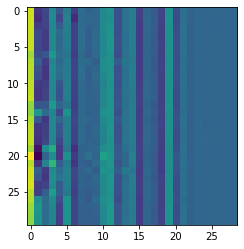

In [12]:
plt.imshow(dataD_train[3000,:,:,:])

In [13]:
def driver_test():    
#     dataD=np.load('./data/dataD.npy',allow_pickle=True)
    dataD=train_data_drivertest#train_data_drivertest[:6622,]
#     dataB=np.load('./data/dataB.npy',allow_pickle=True)
#     dataH=np.load('./data/dataH.npy',allow_pickle=True)
    dataA=test_data#train_data_drivertest[6622:,]
#     dataH = dataH[2000:,:]
#     dataB=dataB[:3000,:]
#     dataA=np.vstack((dataA,dataB))
#     dataA=np.vstack((dataA,dataH))
#     dataA = dataA[1000:,:]
    dataD_normal = dataD
    dataD_anormaly=dataA
    
#     dataD_contrib = np.vstack((dataD_normal,dataD_anormaly))
#     dataD_contrib = norm(dataD_contrib)
#     dataD_contrib = pca(dataD_contrib)
    label_0 = np.full(shape=(len(dataD_normal)),fill_value=0)
    label_1 = np.full(shape=(len(dataD_anormaly)),fill_value=1)
#     idx = np.asarray(list(range(0, dataD_contrib.shape[0])))
    
#     dataD_normal = dataD_contrib[:dataD_normal.shape[0],:]
#     dataD_anormaly = dataD_contrib[dataD_normal.shape[0]:,:]

    num_samples_0 = (dataD_normal.shape[0] - seq_len) // 1
    aa_0 = np.empty([num_samples_0, seq_len, num_singal])
    bb_0 = np.empty([num_samples_0, seq_len, 1])
    bbb_0 = np.empty([num_samples_0, seq_len, 1])
    for j in range(num_samples_0):
        bb_0[j, :, :] = np.reshape(label_0[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_0[j, :, i] = dataD_normal[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_0[j, :, k])-min(aa_0[j, :, k])
#             if A != 0:
#                 aa_0[j, :, k] = (aa_0[j, :, k]-aa_0[j, :, k].min())/(aa_0[j, :, k].max()-aa_0[j, :, k].min())
#             else:
#                 aa_0[j, :, k] = aa_0[j, :, k]

    num_samples_1 = (dataD_anormaly.shape[0] - seq_len) // 1
    aa_1 = np.empty([num_samples_1, seq_len, num_singal])
    bb_1 = np.empty([num_samples_1, seq_len, 1])
    bbb_1 = np.empty([num_samples_1, seq_len, 1])
    for j in range(num_samples_1):
        bb_1[j, :, :] = np.reshape(label_1[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_1[j, :, i] = dataD_anormaly[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_1[j, :, k])-min(aa_1[j, :, k])
#             if A != 0:
#                 aa_1[j, :, k] = (aa_1[j, :, k]-aa_1[j, :, k].min())/(aa_1[j, :, k].max()-aa_1[j, :, k].min())
#             else:
#                 aa_1[j, :, k] = aa_1[j, :, k]

        
        
#     aa_1_A = aa_1[:len(aa_1)//2,:]
#     aa_1_B = aa_1[len(aa_1)//2:,:]
#     bb_1_A = bb_1[:len(aa_1)//2,:]
#     bb_1_B = bb_1[len(aa_1)//2:,:]
#     dataD_test = np.insert(aa_0,1500,aa_1,axis=0)
#     dataD_test = np.insert(dataD_test,5880,aa_1_B,axis=0)
#     labelD_test = np.insert(bb_0,1500,bb_1,axis=0)
#     labelD_test = np.insert(labelD_test,5880,bb_1_B,axis=0)
    dataD_test = np.concatenate((aa_0,aa_1),axis=0)
    labelD_test= np.concatenate((bb_0,bb_1),axis=0)
    labelD_test = np.reshape(labelD_test,[labelD_test.shape[0],labelD_test.shape[1]])
    labelD_test = np.sum(labelD_test,1)
    labelD_test[labelD_test > 1] = 1

    index = [i for i in range(len(dataD_test))]
    random.shuffle(index)
    dataD_test = dataD_test[index]
    labelD_test = labelD_test[index]
    np.save("./DCGAN_score/label_owner"+owner+".npy", labelD_test)

    dataD_test = np.reshape(dataD_test,[dataD_test.shape[0],dataD_test.shape[1],dataD_test.shape[2],1])
    return dataD_test,labelD_test

In [14]:
dataD_test,labelD_test = driver_test()

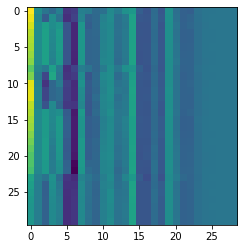

In [15]:
plt.imshow(dataD_test[30184,:,:,:])

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(height*width, use_bias=False, input_shape=(height*width,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((height, width,1)))
    assert model.output_shape == (None, height, width, 1) # Note: None is the batch size
    
    # Layer 2: Hint use layers.Conv2DTranspose with 5x5 kernels and appropriate stride
#     model.add(layers.GaussianNoise(stddev=0.2,input_shape=[height, width, 1]))
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer = 'l2'))
#     assert model.output_shape == (None, height, width, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.5))
    
#     model.add(layers.GaussianNoise(stddev=0.2))
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer = 'l2'))
#     assert model.output_shape == (None, height, width, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.5))

#     # Layer 3
#     model.add(layers.GaussianNoise(stddev=0.2))
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer = 'l2'))
#     assert model.output_shape == (None, height, width, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.5))

#     model.add(layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False))
# #     assert model.output_shape == (None, height*2, width*2, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
# #     model.add(layers.Dropout(0.5))

    #Layer4
    
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
#     assert model.output_shape == (None, height*4, width*4, 1)

    return model

In [17]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 870)               756900    
_________________________________________________________________
batch_normalization (BatchNo (None, 870)               3480      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 870)               0         
_________________________________________________________________
reshape (Reshape)            (None, 30, 29, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 30, 29, 128)       1152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 29, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 29, 128)       0

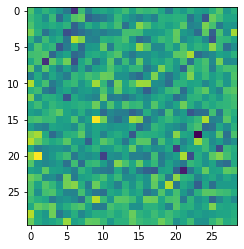

In [26]:
noise = tf.random.normal([1, height*width])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [27]:
generated_image.shape

TensorShape([1, 30, 29, 1])

In [28]:
noise.shape

TensorShape([1, 870])

In [29]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same',input_shape=[height, width, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_regularizer = 'l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', kernel_regularizer = 'l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

#     model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
# #     model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
#     model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1))

    return model

In [30]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 29, 128)       3328      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 29, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 29, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 29, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 29, 64)        73792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 29, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 30, 29, 64)       

In [31]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00195586]], shape=(1, 1), dtype=float32)


In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss*1) + (fake_loss*1)
    return total_loss

In [34]:
def generator_loss(fake_output):
    generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return generator_loss

In [35]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [37]:
EPOCHS = 50
noise_dim = height*width
num_examples_to_generate = 16 # For visualization

# We will reuse this noise_vector overtime (so it's easier)
# to visualize progress in the animated GIF)
noise_vector = tf.random.normal([num_examples_to_generate, noise_dim])

In [38]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('./DCGAN_picture/image_at_'+str(epoch)+'_'+owner+'.png')
  plt.show()

In [39]:
def accuracy(score):
    acc = accuracy_score(labelD_test, score)
    return acc

In [40]:
def plot_acc(acc):
    arrange=np.arange(0, len(acc), 1, dtype=np.int32)
    plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
    plt.plot(arrange,acc,'b', c='red',label = "acc")
    plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
    plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
    plt.legend(loc = "best", fontsize=10)
    plt.savefig('./DCGAN_picture/image_at_acc_'+owner+'.png')
    plt.show()

In [41]:
# def evaluate():    
#     score = np.empty([labelD_test.shape[0]])
#     for i in range(len(dataD_test)):
#         a=0
#         test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1],dataD_test[i].shape[2]])
#         d=discriminator(test)
#         if d > 0:
#             a=0
#         else:
#             a=1
#         score[i]=a
#     return score
def evaluate():    
    score = np.empty([labelD_test.shape[0]])
    for i in range(len(dataD_test)):
        noise = tf.random.normal([1, noise_dim])
        test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1]])
        test_a = np.reshape(test,[height,width])
        generated_image=generator(noise, training=False)
        generated_image_a = np.reshape(generated_image,[height,width])
        a=mean_squared_error(test_a, generated_image_a)
        score[i]=a
    return score

In [42]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generator output
        generated_images = generator(noise, training=True)
        
      # Discriminator output
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True) 
      
      # Loss functions
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
  
    # Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [43]:
def train(dataset, epochs):
      score1 = np.empty([labelD_test.shape[0]])
      gen_loss =np.empty([EPOCHS])
      disc_loss =np.empty([EPOCHS])
      acc = np.zeros([int(EPOCHS/epoch_dura)])
      for epoch in range(epochs):
        start = time.time()
        if epoch%epoch_dura ==0:
            score = evaluate()
            score1 = np.vstack((score1,score))
#             acc[int(epoch/epoch_dura)] = accuracy(score)
#             plot_acc(acc)

        for image_batch in dataset:
            gen_loss[epoch],disc_loss[epoch]=train_step(image_batch)


        # Produce images for the GIF as we go
#         display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 noise_vector)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
#         display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epochs,
                               noise_vector)
      np.save("./DCGAN_score/score_owner"+owner+".npy", score1)
      np.save("./DCGAN_loss/gloss_owner"+owner+".npy", gen_loss)
      np.save("./DCGAN_loss/dloss_owner"+owner+".npy", disc_loss)

In [44]:
# BUFFER_SIZE = 60000
BATCH_SIZE = 64
dataD_train=dataD_train.astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(dataD_train).shuffle(dataD_train.shape[0]).batch(BATCH_SIZE)

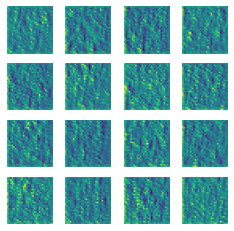

Time for epoch 1 is 153.1503267288208 sec


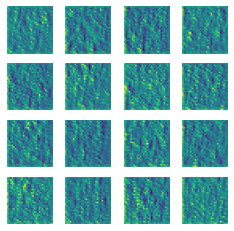

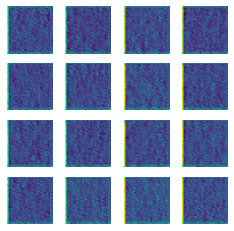

Time for epoch 2 is 1.6091554164886475 sec


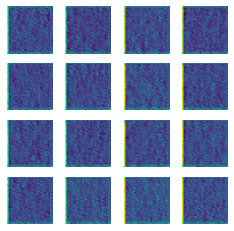

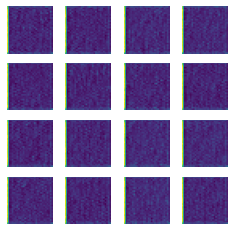

Time for epoch 3 is 1.5242037773132324 sec


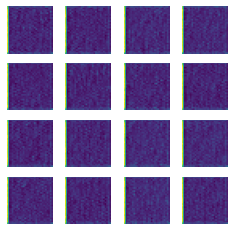

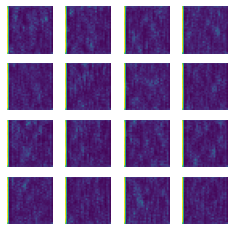

Time for epoch 4 is 1.5250670909881592 sec


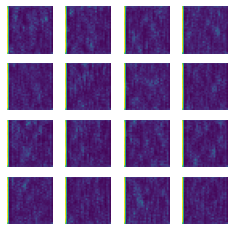

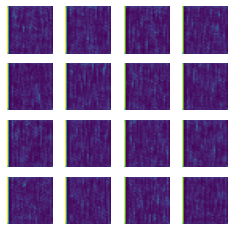

Time for epoch 5 is 1.6073453426361084 sec


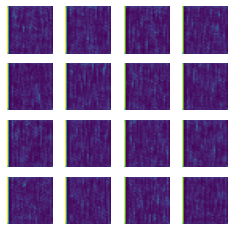

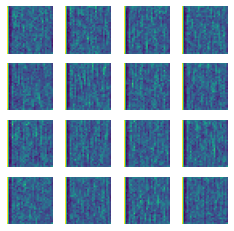

Time for epoch 6 is 151.45988059043884 sec


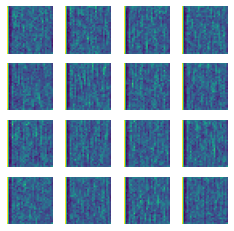

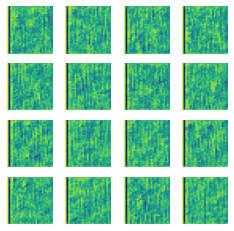

Time for epoch 7 is 1.52138090133667 sec


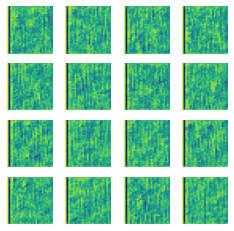

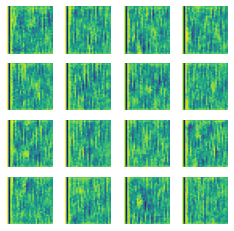

Time for epoch 8 is 1.5303285121917725 sec


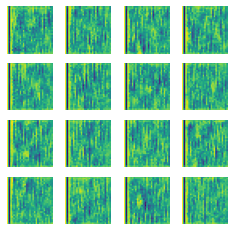

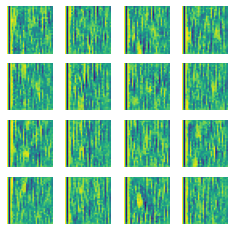

Time for epoch 9 is 1.608088493347168 sec


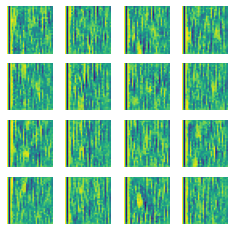

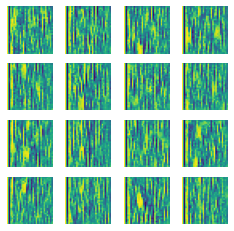

Time for epoch 10 is 1.516420841217041 sec


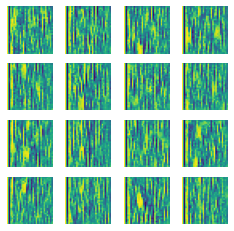

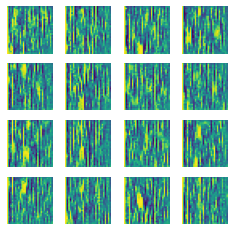

Time for epoch 11 is 151.49669575691223 sec


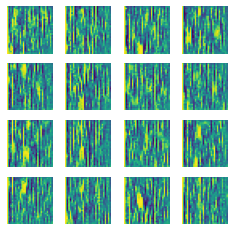

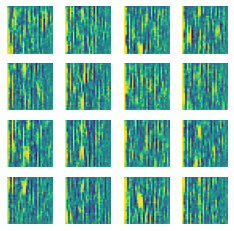

Time for epoch 12 is 1.6017096042633057 sec


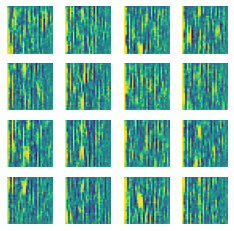

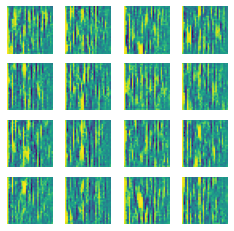

Time for epoch 13 is 1.5967717170715332 sec


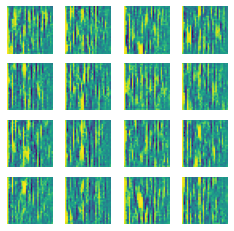

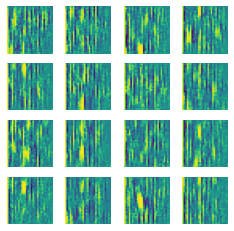

Time for epoch 14 is 1.5215952396392822 sec


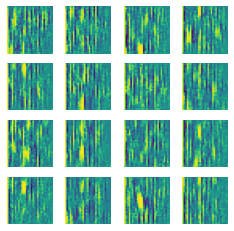

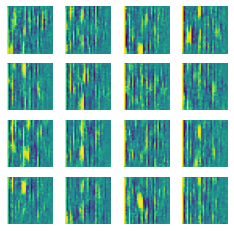

Time for epoch 15 is 1.5869483947753906 sec


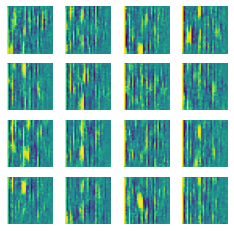

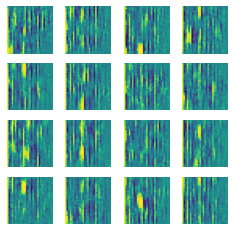

Time for epoch 16 is 151.3695831298828 sec


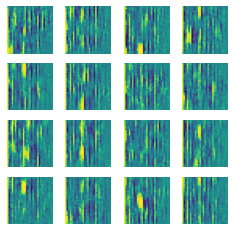

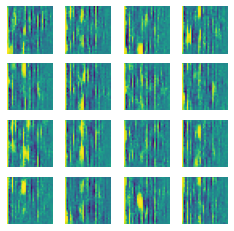

Time for epoch 17 is 1.5187804698944092 sec


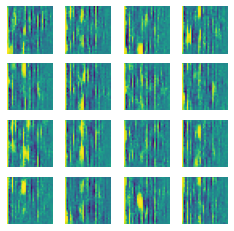

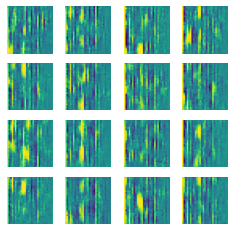

Time for epoch 18 is 1.5343401432037354 sec


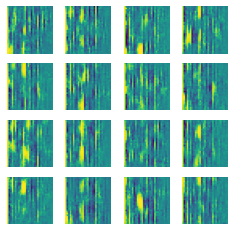

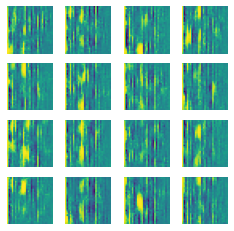

Time for epoch 19 is 1.5299084186553955 sec


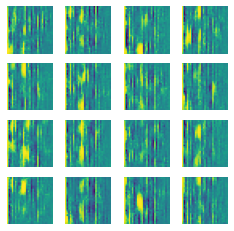

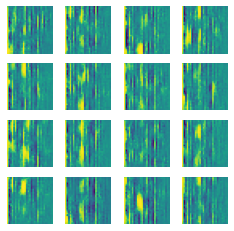

Time for epoch 20 is 1.6196341514587402 sec


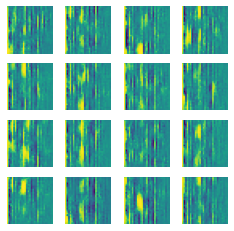

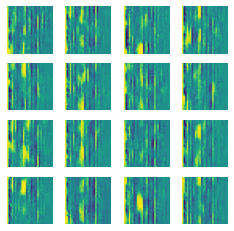

Time for epoch 21 is 151.43777179718018 sec


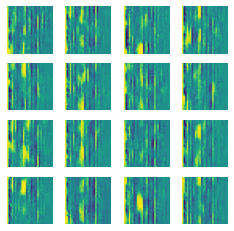

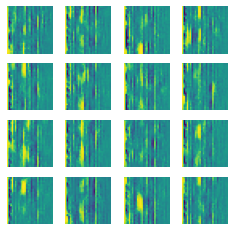

Time for epoch 22 is 1.5279405117034912 sec


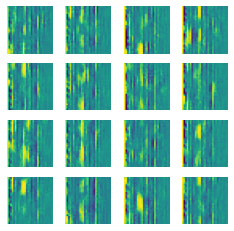

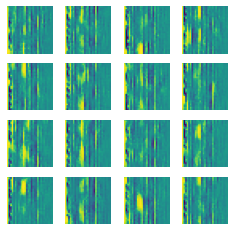

Time for epoch 23 is 1.6115057468414307 sec


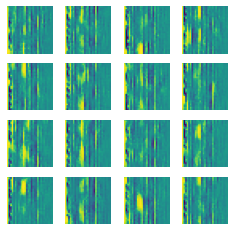

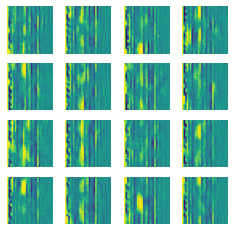

Time for epoch 24 is 1.5995290279388428 sec


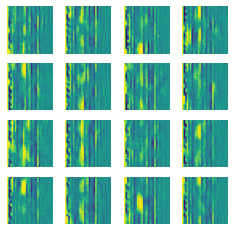

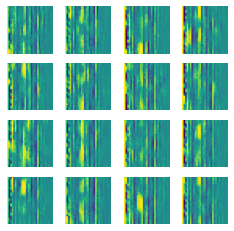

Time for epoch 25 is 1.5294806957244873 sec


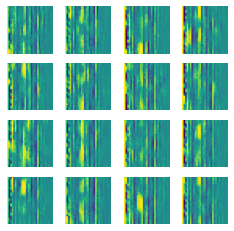

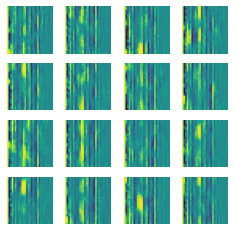

Time for epoch 26 is 151.4805269241333 sec


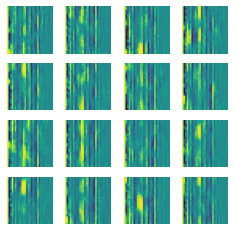

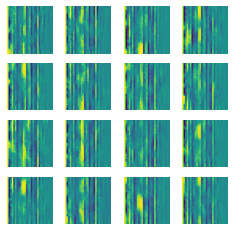

Time for epoch 27 is 1.6001965999603271 sec


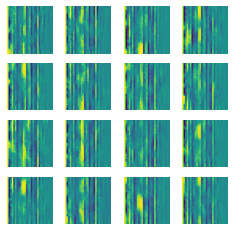

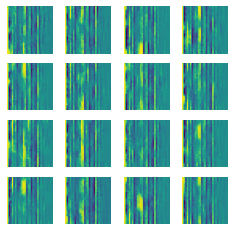

Time for epoch 28 is 1.529453992843628 sec


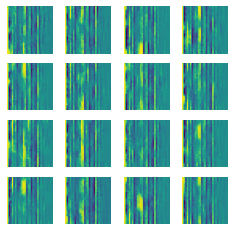

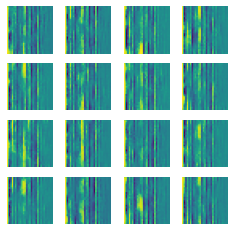

Time for epoch 29 is 1.5225825309753418 sec


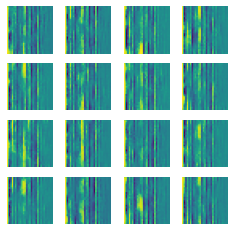

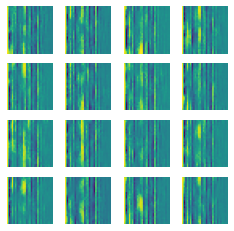

Time for epoch 30 is 1.587148666381836 sec


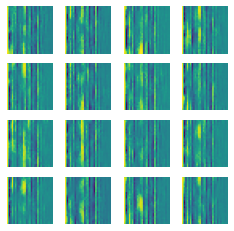

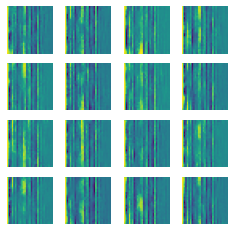

Time for epoch 31 is 151.2071681022644 sec


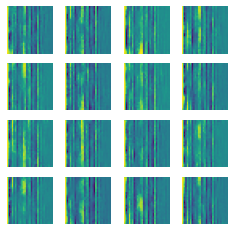

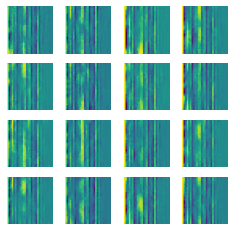

Time for epoch 32 is 1.5247323513031006 sec


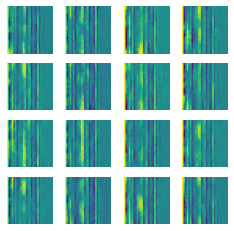

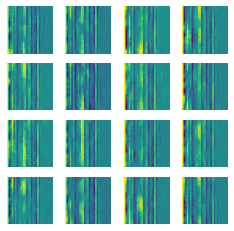

Time for epoch 33 is 1.5206096172332764 sec


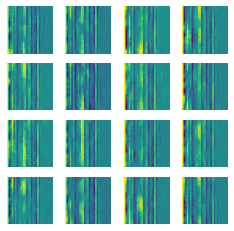

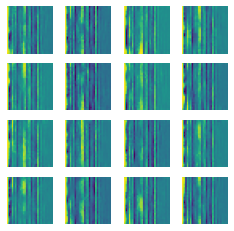

Time for epoch 34 is 1.6037349700927734 sec


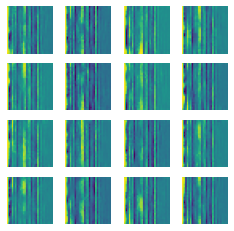

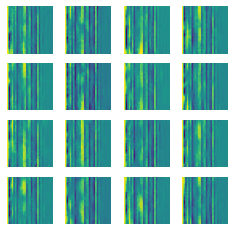

Time for epoch 35 is 1.596609115600586 sec


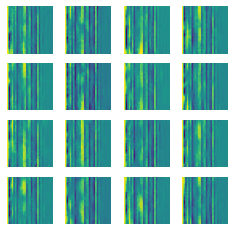

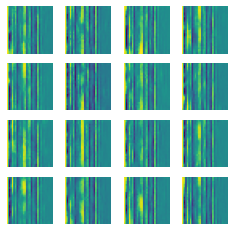

Time for epoch 36 is 151.53373837471008 sec


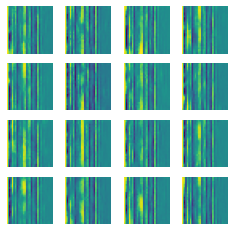

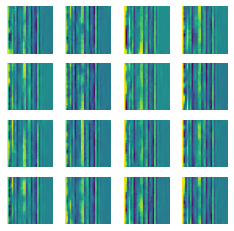

Time for epoch 37 is 1.5311689376831055 sec


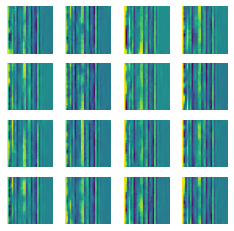

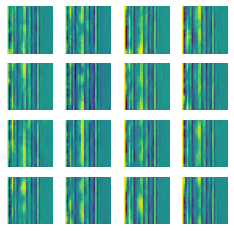

Time for epoch 38 is 1.6060161590576172 sec


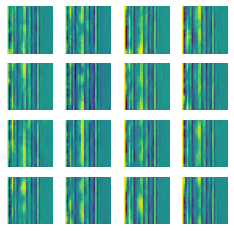

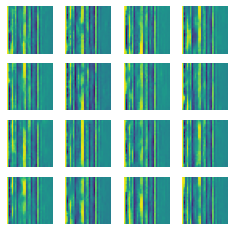

Time for epoch 39 is 1.529170274734497 sec


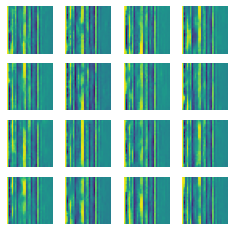

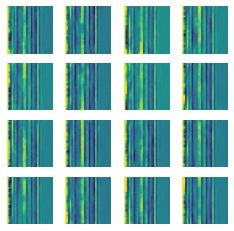

Time for epoch 40 is 1.5210111141204834 sec


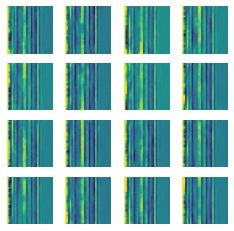

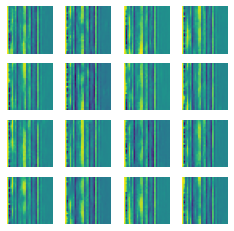

Time for epoch 41 is 151.33291625976562 sec


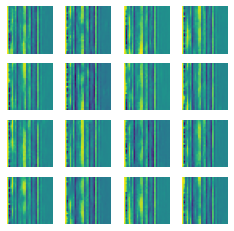

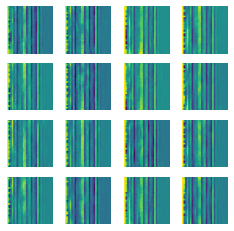

Time for epoch 42 is 1.605447769165039 sec


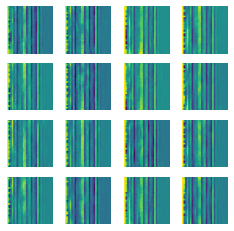

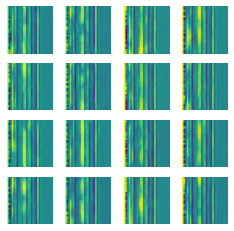

Time for epoch 43 is 1.5304300785064697 sec


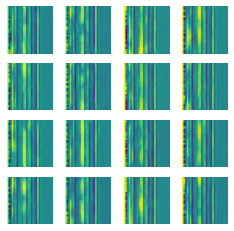

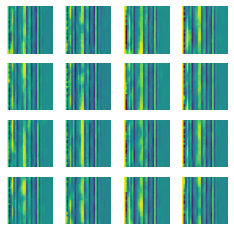

Time for epoch 44 is 1.5233280658721924 sec


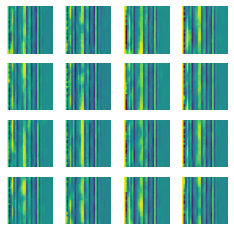

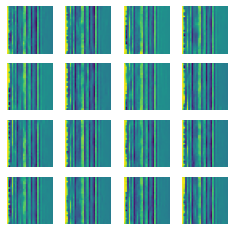

Time for epoch 45 is 1.6608688831329346 sec


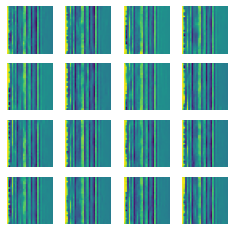

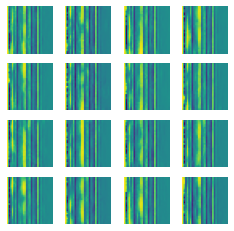

Time for epoch 46 is 151.8101031780243 sec


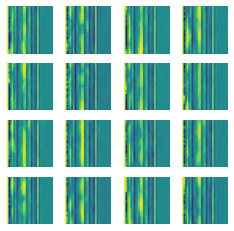

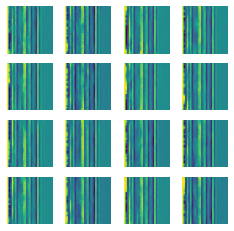

Time for epoch 47 is 1.5207903385162354 sec


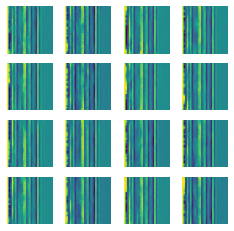

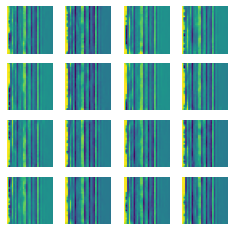

Time for epoch 48 is 1.519791841506958 sec


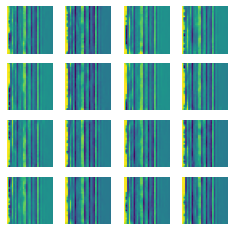

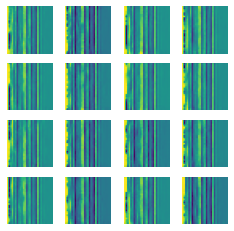

Time for epoch 49 is 1.601163387298584 sec


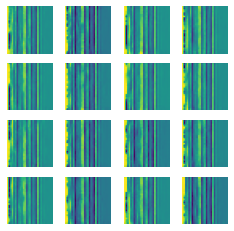

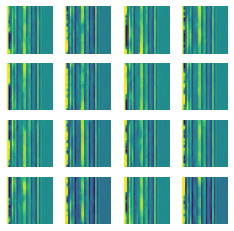

Time for epoch 50 is 1.5112366676330566 sec


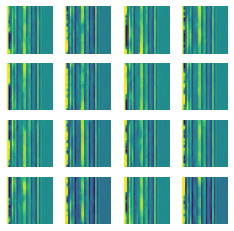

Wall time: 26min 37s


In [38]:
%%time
train(train_dataset, EPOCHS)

In [39]:
score1=np.load('./DCGAN_score/score_owner'+owner+'.npy',allow_pickle=True)
labelD_test=np.load('./DCGAN_score/label_owner'+owner+'.npy',allow_pickle=True)
gen_loss=np.load('./DCGAN_loss/gloss_owner'+owner+'.npy', allow_pickle=True)
disc_loss=np.load('./DCGAN_loss/dloss_owner'+owner+'.npy', allow_pickle=True)

In [40]:
# start = time.time()
# score = np.empty([labelD_test.shape[0]])
# for i in range(len(dataD_test)):
#     a=0
#     test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1],dataD_test[i].shape[2]])
#     d=discriminator(test)
#     if d > 0:
#         a=0
#     else:
#         a=1
#     score[i]=a
# print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [41]:
# print ('Time for epoch {} is {} sec'.format(1, time.time()-start))

In [56]:
D_L = np.empty([score1.shape[1]])
precision = np.empty([score1.shape[0]-1])
recall = np.empty([score1.shape[0]-1])
f1 = np.empty([score1.shape[0]-1])
acc = np.empty([score1.shape[0]-1])
for j in range (score1.shape[0]-1):
    for i in range(score1.shape[1]):
        if score1[j+1][i]>0.1:
            # true/negative
            D_L[i] = 1
        else:
            # false/positive
            D_L[i] = 0
    precision[j], recall[j], f1[j], _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')
    acc[j] = accuracy_score(labelD_test, D_L)

In [59]:
a=0
b=0
c=6
for i in range (len(score1[1])):
    if score1[c][i]<=0.1:
        a = a + score1[c][i]
        b=b+1
a=a/b
a

0.09536158986091602

In [ ]:
# from sklearn.metrics import precision_recall_fscore_support,accuracy_score
# precision = np.empty([score1.shape[0]-1])
# recall = np.empty([score1.shape[0]-1])
# f1 = np.empty([score1.shape[0]-1])
# acc = np.empty([score1.shape[0]-1])
# for i in range (score1.shape[0]-1):
#     precision[i], recall[i], f1[i], _ = precision_recall_fscore_support(labelD_test, score1[i+1], average='binary')
#     acc[i] = accuracy_score(labelD_test, score1[i+1])

In [57]:
acc

array([0.84381611, 0.82212555, 0.82212555, 0.82209576, 0.82147007,
       0.82179781, 0.81369365, 0.81360427, 0.80615559, 0.81131007])

In [ ]:
precision

In [ ]:
recall

In [ ]:
arrange=np.arange(0, 50, 5, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange,acc,'b', c='red',label = "acc")
plt.plot(arrange,precision,'b', c='green',label = "precision")
plt.plot(arrange,recall,'b', c='pink',label = "recall")
plt.plot(arrange,f1,'b', c='blue',label = "f1")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
# plt.savefig("./picture/driverA&D_fuel comsumption.png")

In [ ]:
arrange1=np.arange(0, 50, 1, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange1,gen_loss,'b', c='green',label = "g_loss")
plt.plot(arrange1,disc_loss, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
# plt.savefig("./picture/driverA&D_fuel comsumption.png")